<a href="https://colab.research.google.com/github/shwe24/Aspect-Based-Sentiment-Classification/blob/main/Aspect_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import os
from google.colab import drive
USE_GOOGLE_DRIVE = True
if USE_GOOGLE_DRIVE:
    drive.mount('/content/drive')
    PATH_PREFIX = 'drive/My Drive/ABSA'
else:
    PATH_PREFIX = '..'

train_data=os.path.join(
    PATH_PREFIX, 'Laptops_Train_v2.xml'
)
test_data=os.path.join(
    PATH_PREFIX, 'Laptops_Test_Gold.xml'
)

Mounted at /content/drive


# Aspect Extraction - using ML models

In [ ]:
import pandas as pd


# convert into bio format
class BIO:

    def convert_into_bio(self, text, predicted_aspect_terms_list, common_words_list):
        text_list = text.split()
        # print(text_list)
        df = pd.DataFrame({'text': text_list, 'BIO': 'O'})

        bio_dict = self.bio_mapper(common_words_list=common_words_list, prediction=predicted_aspect_terms_list)
        bio_filtered_dict = self.filter_predicted_words(bio_dict)

        for item in bio_filtered_dict:
            final_list = self.matcher(text, item)
            if final_list[1] - final_list[0] == 0:
                df.at[final_list[0], 'BIO'] = 'B'
            else:
                df.at[final_list[0], 'BIO'] = 'B'
                for index in range(final_list[0] + 1, final_list[1] + 1):
                        df.at[index, 'BIO'] = 'I'

        return df

    def bio_mapper(self, common_words_list, prediction):
        bio_dict = dict()

        for i in range(len(common_words_list)):
            bio_dict[common_words_list[i]] = prediction[i]

        return bio_dict

    def matcher(self, text, word):
        split_word = word.split()
        split_text = text.split(word)
        start=0
        end=0
        if len(split_text) > 1:
            start = len(split_text[0].split())
            end = start + len(split_word) - 1
        return start, end

    def filter_predicted_words(self, _dict):

        final_list = []

        for key, value in _dict.items():
            if value == 1:
                final_list.append(key)

        return final_list;


def main():

    text = "The battery life is really good and its size is reasonable"
    x = BIO()
    prd = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    common_words = ['OS',
                    'Vista',
                    'Windows',
                    'Windows 7',
                    'applications',
                    'battery',
                    'battery life',
                    'carry',
                    'charge',
                    'cost',
                    'design',
                    'display',
                    'extended warranty',
                    'features',
                    'games',
                    'gaming',
                    'graphics',
                    'hard drive',
                    'keyboard',
                    'keys',
                    'look',
                    'memory',
                    'motherboard',
                    'mouse',
                    'operating system',
                    'performance',
                    'power',
                    'power supply',
                    'price',
                    'processor',
                    'program',
                    'programs',
                    'quality',
                    'runs',
                    'screen',
                    'service',
                    'shipping',
                    'size',
                    'software',
                    'speakers',
                    'speed',
                    'system',
                    'use',
                    'value',
                    'warranty',
                    'warrenty',
                    'weight',
                    'windows',
                    'work',
                    'works']

    print(x.convert_into_bio(text, prd, common_words_list=common_words))

if __name__ == '__main__':
  main()

          text BIO
0          The   O
1      battery   B
2         life   I
3           is   O
4       really   O
5         good   O
6          and   O
7          its   O
8         size   B
9           is   O
10  reasonable   O


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd


pd.set_option('display.max_colwidth', -1)

class Xml2DataFrame:

    @staticmethod
    def parse_root(root):
        """Return pandas dataframe from given xml data"""
        data_list = []
        xml_data = dict()

        target_words = []
        for child in root:
            xml_data['id'] = child.attrib.get('id')
            text = child.find('text').text.lower()
            xml_data['text'] = text
            for aspectTerms in child.iter('aspectTerms'):
                aspectInfos = []
                for asp_term in aspectTerms:
                    aspectInfos.append(asp_term.attrib)
                    # print(asp_term.attrib)
                xml_data['aspect_info'] = aspectInfos
            data_list.append(xml_data)
            xml_data = {}

        return data_list

    def process_data(self, path):
        root = ET.parse(path).getroot()
        """ Initiate the root XML, parse it, and return a dataframe"""
        structure_data = self.parse_root(root)
        df = pd.DataFrame([[k.get('id'), k.get('text'), k.get('aspect_info')] for k in iter(structure_data)],
                          columns=['id', 'text', 'aspect_info'])
        return df


if __name__ == '__main__':
    xml2df = Xml2DataFrame()
    xml_dataframe = xml2df.process_data(test_data)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [ ]:
import nltk
from nltk.corpus import stopwords
from string import punctuation


class POSTagger:

    @staticmethod
    def pos_tagger(text):
        text = nltk.word_tokenize(text)
        stopwords_en = stopwords.words('english')
        stopwords_en_withpunct = set(stopwords_en).union(set(punctuation))
        text = [word for word in text if word not in stopwords_en_withpunct]
        tagged_pos_list = nltk.pos_tag(text)
        return tagged_pos_list

    def filter_pos_tag(self, tagged_text):
        final_text_list = []
        matching_tag = ['NN','NNS','NNP','NNPS','RB','RBR','RBS','JJ','JJR','JJS','VB','VBD','VBG','VBN','VBP','VBZ']

        for word, tag in tagged_text:
            final_text = []
            if tag in matching_tag:
                final_text.append(word)
                final_text_list.append((' '.join(final_text)))
        return self.combine(final_text_list)

    @staticmethod
    def combine(filtered_tags):
        filtered_string = ' '.join(filtered_tags)
        return filtered_string


if __name__ == '__main__':
    x = POSTagger()
    k = x.pos_tagger("The battery life is really good and its size is reasonable")
    y = x.filter_pos_tag(k)

In [ ]:
import pandas as pd
from sklearn.externals import joblib
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from scipy.sparse import hstack
import warnings



/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# xml parser
def get_xml_data(path):
    xml2df = Xml2DataFrame()
    xml_dataframe = xml2df.process_data(path)
    return xml_dataframe

#get_xml_data(train_data)

In [ ]:
train_dataframe = get_xml_data(train_data)
# print(train_dataframe.head())
train_text_list = train_dataframe['text']
train_aspects_list = list(train_dataframe['aspect_info'])
print(train_text_list.head())
print("=============================")
print(train_aspects_list[:5])

0    i charge it at night and skip taking the cord with me because of the good battery life.                                                                                            
1    i bought a hp pavilion dv4-1222nr laptop and have had so many problems with the computer.                                                                                          
2    the tech guy then said the service center does not do 1-to-1 exchange and i have to direct my concern to the "sales" team, which is the retail shop which i bought my netbook from.
3    i investigated netbooks and saw the toshiba nb305-n410bl.                                                                                                                          
4    the other day i had a presentation to do for a seminar at a large conference in town- lots of people, little time to prep and have to set up a computer to a projector, etc.       
Name: text, dtype: object
[[{'term': 'cord', 'polarity': 'neutral', 'from':

In [ ]:

# POSTag function wrapper
def pos_tag(review):
    tagged_text_list = []
    pos_tagger = POSTagger()
    for text in review:
        tagged_text_list.append(pos_tagger.pos_tagger(text=text))
    return tagged_text_list


# POSTag filtering of noun,adjective,verb,adverb
def filter_tag(tagged_reviews):
    filtered_list = []
    pos_tagger = POSTagger()
    for tagged_review in tagged_reviews:
        filtered_list.append(pos_tagger.filter_pos_tag(tagged_review))
    return filtered_list

In [ ]:
# tag POS
tagged_text_list_train = pos_tag(train_text_list)
joblib.dump(tagged_text_list_train, 'tagged_text_list_train.pkl')
tagged_text_list_train = joblib.load('tagged_text_list_train.pkl')
# print(tagged_text_list_train[:5])

In [ ]:
# train list after filtering
final_train_text_list = filter_tag(tagged_text_list_train)

print(final_train_text_list[:5])

['charge night skip taking cord good battery life', 'bought hp pavilion dv4-1222nr laptop many problems computer', 'tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook', 'investigated netbooks saw toshiba nb305-n410bl', 'day presentation seminar large conference town- lots people little time prep set computer projector etc']


In [ ]:
#Selecting only 20 most common aspect.
def get_most_common_aspect(aspect_list):
    import nltk
    aspect_terms = []

    aspect_list = list(aspect_list.aspect_info)

    for inner_list in aspect_list:
        if inner_list is not None:
            for _dict in inner_list:
                # for key in _dict:
                aspect_terms.append(_dict.get('term'))

    most_common_aspect = [k for k, v in nltk.FreqDist(aspect_terms).most_common(1000)]
    return most_common_aspect

In [ ]:
# generate data frame
def get_data_frame(text_list, train_aspects_list, most_common_aspect):
    data = {'Text': text_list}
    df = pd.DataFrame(data)
    for inner_list in train_aspects_list:
        if inner_list is not None:
            for _dict in inner_list:
                # for key in _dict:
                if _dict.get('term') in most_common_aspect:
                    df.loc[train_aspects_list.index(inner_list), _dict.get('term')] = _dict.get('polarity')
    return df

In [ ]:

# generate data frame for aspect extraction task
def get_aspect_data_frame(df, most_common_aspect):
    for common_aspect in most_common_aspect:
        df[common_aspect] = df[common_aspect].replace(['positive','negative','neutral','conflict'],[1,1,1,1])
    df = df.fillna(0)
    return df

In [ ]:

most_common_aspect = get_most_common_aspect(train_dataframe)
print(most_common_aspect)

['screen', 'price', 'use', 'battery life', 'battery', 'keyboard', 'programs', 'software', 'features', 'warranty', 'hard drive', 'quality', 'size', 'performance', 'speed', 'Windows', 'memory', 'graphics', 'applications', 'motherboard', 'runs', 'Vista', 'gaming', 'system', 'program', 'works', 'charge', 'design', 'display', 'power supply', 'Windows 7', 'service', 'operating system', 'windows', 'warrenty', 'value', 'keys', 'mouse', 'OS', 'speakers', 'extended warranty', 'shipping', 'games', 'cost', 'work', 'processor', 'look', 'hardware', 'power', 'weight', 'carry', 'fan', 'Keyboard', 'touchpad', 'trackpad', 'feature', 'boot up', 'webcam', 'internet', 'sound', 'touch pad', 'iWork', 'screen size', 'Windows 7 Starter', 'tech support', 'Screen', 'drivers', 'navigate', 'hinge', 'mousepad', 'iTunes', 'cd drive', 'space', 'iPhoto', 'RAM', 'edges', 'buttons', 'portability', 'service center', 'mother board', 'web browsing', 'iMovie', 'monitor', 'iLife', 'set up', 'HD', 'DVD burner', 'USB ports', '

In [ ]:
#get data frame
df_train = get_data_frame(final_train_text_list,train_aspects_list, most_common_aspect)

In [ ]:
# get expect term df
df_train_aspect = get_aspect_data_frame(df_train, most_common_aspect)
df_train_aspect.head()

,Text,cord,battery life,service center,"""sales"" team",tech guy,quality,GUI,applications,use,start up,features,iChat,Photobooth,garage band,screen,power light,hard drive light,battery,rubber enclosure,edge,multi-touch gestures,tracking area,external mouse,gaming,suite of software,speed,Windows 7,usb devices,keyboard,software,system,Microsoft office for the mac,syncing,"30"" HD Monitor",boot up,service,operating system,preloaded software,price,...,"15""","17""",feel,virus protection programs for a Mac,HDMI,wireless switch,technical person,driver/application DVD,photo detection software,mouse pointer,engineering design,hinges,Customer Service,pointer,life span,looks,my toshiba feature,layout,one of the programs,iwork,office,document creation,memory stick,button below the mouse pad,lightscribe,photo application,17 ince screen,warranty period,Performance,Battery Life,Price,Value,WiFi,update programs,MS applications,Internet tabs,noises,bottom of the computer,repair technician,repair
0,charge night skip taking cord good battery life,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,bought hp pavilion dv4-1222nr laptop many problems computer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tech guy said service center 1-to-1 exchange direct concern sales team retail shop bought netbook,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,investigated netbooks saw toshiba nb305-n410bl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,day presentation seminar large conference town- lots people little time prep set computer projector etc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train_aspect = df_train_aspect.reindex(sorted(df_train_aspect.columns), axis=1)
df_train_aspect.head()

,"""sales"" team",1 GB ram,1-year-warranty,10-key,12 cell battery,13 inch,15 inch,"15""",16GB RAM support,17 ince screen,17 inch screen,"17""","17"" inch screen",17-inch screen,"18.4"" screen",1GB of RAM,2 GB of RAM,"22"" Monitor",2GB RAM stick,2GB stick of memory,3 year warranty,"30"" HD Monitor",3G network,4GB of RAM,4GB stick of RAM,500gb external hard drive,500gb hard drive,8GB RAM,8GB of RAM,9 punds,AC plug,AC power port,AMD Turin processor,ASUS TECH SUPPORT,ATI graphics card,Acer screen,Adobe Creative Suite,Adobe Creative apps,Adobe Flash player,AfterEffects programs,...,warrentys,watching movies,web browsing,web cam,web programming software,webcam,webpages,weighed,weight,wheel,wifi,wifi card,windows,windows 7,windows 7 home premium,windows 7 system,windows OS,windows disc,windows logon,windows media,windows system,windows vista,windows vista system,windows xp,wired lan,wireless card,wireless internet access,wireless mouse,wireless switch,wireless system,word,word editing,word processer,word processing,word processing program,word processor,work,working,works,wt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Similar for test list
test_dataframe = get_xml_data(test_data)
test_text_list = train_dataframe['text']
test_aspects_list = list(train_dataframe['aspect_info'])

In [ ]:
tagged_text_list_test = pos_tag(test_text_list)
joblib.dump(tagged_text_list_test, 'tagged_text_list_test.pkl')
tagged_text_list_test=joblib.load('tagged_text_list_test.pkl')

In [ ]:
final_test_text_list = filter_tag(tagged_text_list_test)

In [ ]:
df_test = get_data_frame(final_test_text_list,test_aspects_list, most_common_aspect)
df_test_aspect = get_aspect_data_frame(df_test, most_common_aspect)
df_test_aspect = df_test_aspect.reindex(sorted(df_test_aspect.columns), axis=1)

In [ ]:
# Sort the data frame according to aspect's name and separate data(X) and target(y)
# df_train_aspect = df_train_aspect.sample(frac=1).reset_index(drop=True) # For randomization
X_train= df_train_aspect.Text
y_train = df_train_aspect.drop('Text', 1)
print(y_train[:5])


# df_test_aspect = df_test_aspect.sample(frac=1).reset_index(drop=True) # For randomization
X_test = df_test_aspect.Text
y_test = df_test_aspect.drop('Text', 1)
final_most_common_aspect = list(y_train)


   "sales" team  1 GB ram  1-year-warranty  10-key  ...  work  working  works   wt
0  0.0           0.0       0.0              0.0     ...  0.0   0.0      0.0    0.0
1  0.0           0.0       0.0              0.0     ...  0.0   0.0      0.0    0.0
2  1.0           0.0       0.0              0.0     ...  0.0   0.0      0.0    0.0
3  0.0           0.0       0.0              0.0     ...  0.0   0.0      0.0    0.0
4  0.0           0.0       0.0              0.0     ...  0.0   0.0      0.0    0.0

[5 rows x 1000 columns]


In [ ]:
# Change y_train to numpy array
import numpy as np
y_train = np.asarray(y_train, dtype=np.int64)
y_test = np.asarray(y_test, dtype=np.int64)
print(y_train[:5])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# Generate word vecotors using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# from nltk import word_tokenize          
# from nltk.stem import WordNetLemmatizer 
vect = CountVectorizer(max_df=1.0, stop_words='english')  
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

In [ ]:
# Create various models. These are multi-label models.
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
nb_classif = OneVsRestClassifier(MultinomialNB()).fit(X_train_dtm, y_train)
C = 1.0 
# SVregularization parameter
svc = OneVsRestClassifier(svm.SVC(kernel='linear', C=C)).fit(X_train_dtm, y_train)
lin_svc = OneVsRestClassifier(svm.LinearSVC(C=C)).fit(X_train_dtm, y_train)
sgd = OneVsRestClassifier(SGDClassifier(max_iter=1000)).fit(X_train_dtm,y_train)



In [ ]:
clf_sent =tree.DecisionTreeClassifier().fit(X_train_dtm,y_train)

In [ ]:
# Predict the test data using classifiers
y_pred_class = nb_classif.predict(X_test_dtm)
y_pred_class_svc = svc.predict(X_test_dtm)
y_pred_class_lin_svc = lin_svc.predict(X_test_dtm)
y_pred_class_sgd = sgd.predict(X_test_dtm)
y_pred_sent=clf_sent.predict(X_test_dtm)

In [ ]:
!pip3 install --upgrade tensorflow 

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [ ]:
from keras.preprocessing.text import Tokenizer

vocab_size = 3644 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
aspect_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_train))
#aspect_tokenized

In [ ]:
# Following code to test metrics of all aspect extraction classifiers
from sklearn import metrics

In [ ]:

print('NB-classifier:',metrics.accuracy_score(y_test,y_pred_class))
print('SVM',metrics.accuracy_score(y_test,y_pred_class_svc))
#print('Linear SVM:',metrics.accuracy_score(y_test,y_pred_class_lin_svc))
#print('SGD classifier',metrics.accuracy_score(y_test,y_pred_class_sgd))
#print('RF classifier',metrics.accuracy_score(y_test,y_pred_class_rf))
print('tree classifier',metrics.accuracy_score(y_test,y_pred_sent))

NB-classifier: 0.5822660098522168
SVM 0.8894909688013136
tree classifier 0.7973727422003285


In [ ]:
print(metrics.precision_score(y_test,y_pred_class,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_lin_svc,average='micro'))
print(metrics.precision_score(y_test,y_pred_class_sgd,average='micro'))

0.9232558139534883
0.9968138370505234
0.9968340117593849
0.9945280437756497


In [ ]:
# stored trained model
joblib.dump(sgd, 'trained_sgd.pkl')

['trained_sgd.pkl']

In [ ]:


def BIO_format(text, predicted_output, common_words):
    bio_obj = BIO()
    df = bio_obj.convert_into_bio(text, predicted_output, common_words_list=common_words)
    return df

In [ ]:
def get_dict_aspect(y,most_common_aspect):
    position=[]
    for innerlist in y:
        position.append([i for i, j in enumerate(innerlist) if j == 1])
    sorted_common=sorted(most_common_aspect)
    dict_aspect=[]
    for innerlist in position:
        inner_dict={}
        for word in sorted_common:
            if sorted_common.index(word) in innerlist:
                inner_dict[word]= 5
            else:
                inner_dict[word]=0
        dict_aspect.append(inner_dict)
    return dict_aspect

In [ ]:

# Aspect term extractor of user's input.
#user_input=input("Enter a laptop review:\n\n")
user_input = "The battery life is really good and its size is reasonable"
#user_input = "it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous."
# Preprocessing and vectorizing
tagged_user_input = pos_tag([user_input])
#print(tagged_user_input)
filter_tagged_user_input = filter_tag(tagged_user_input)
#print(filter_tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
#print(user_input_series)
user_input_series_dtm = vect.transform(user_input_series)
#print(user_input_series_dtm)
# print(user_input_series[:5])

predict_aspect= lin_svc.predict(user_input_series_dtm)
#print(predict_aspect)
# predict_aspect_data = predict_aspect[0]
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
#extra_feature
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

,text,BIO
0,The,B
1,battery,B
2,life,I
3,is,O
4,really,O
5,good,O
6,and,O
7,its,O
8,size,B
9,is,O


In [ ]:
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

,text,BIO
0,The,B
1,battery,B
2,life,I
3,is,O
4,really,O
5,good,O
6,and,O
7,its,O
8,size,B
9,is,O


In [ ]:
# Aspect term extractor of user's input.
user_input=input("Enter a laptop review:\n\n")
#user_input = "The battery life is really good and its size is reasonable"
#user_input = "it is of high quality, has a killer GUI, is extremely stable, is highly expandable, is bundled with lots of very good applications, is easy to use, and is absolutely gorgeous."
# Preprocessing and vectorizing
tagged_user_input = pos_tag([user_input])
#print(tagged_user_input)
filter_tagged_user_input = filter_tag(tagged_user_input)
#print(filter_tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
#print(user_input_series)
user_input_series_dtm = vect.transform(user_input_series)
#print(user_input_series_dtm)
# print(user_input_series[:5])

predict_aspect= lin_svc.predict(user_input_series_dtm)
# predict_aspect_data = predict_aspect[0]
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
#extra_feature
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
df

Enter a laptop review:




,text,BIO


# Aspect extraction using Deep learning models

---



In [ ]:
from keras.layers import Layer
import keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-09 17:41:10--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.158
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.76.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  76.4MB/s    in 21s     

2020-12-09 17:41:32 (74.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
!gunzip GoogleNews-vectors-negative300.bin.gz

gzip: GoogleNews-vectors-negative300.bin already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [ ]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [ ]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
from keras.optimizers import Adam

In [ ]:
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(10000, embed_dim,input_length = 28))
model.add(Bidirectional(LSTM(lstm_out,return_sequences=True)))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(attention())
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1000, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 28, 128)           1280000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 28, 392)           509600    
_________________________________________________________________
lstm_16 (LSTM)               (None, 196)               461776    
_________________________________________________________________
attention_7 (attention)      (196,)                    392       
_________________________________________________________________
flatten_1 (Flatten)          (196, 1)                  0         
_________________________________________________________________
dropout_5 (Dropout)          (196, 1)                  0         
_________________________________________________________________
dense_7 (Dense)              (196, 1000)              

In [ ]:
model=OneVsRestClassifier(MultinomialNB())
history_model=model.fit(X_train_dtm, y_train)

In [ ]:
history_object = model.fit(trainX, trainY, epochs=5,batch_size=8)

Epoch 1/5
160/160 [==============================] - 194s 1s/step - loss: 1.0406 - accuracy: 0.6474
Epoch 2/5
160/160 [==============================] - 195s 1s/step - loss: 0.7027 - accuracy: 0.7537
Epoch 3/5
160/160 [==============================] - 194s 1s/step - loss: 0.6119 - accuracy: 0.7647
Epoch 4/5
160/160 [==============================] - 195s 1s/step - loss: 0.5528 - accuracy: 0.7756
Epoch 5/5
160/160 [==============================] - 195s 1s/step - loss: 0.4975 - accuracy: 0.7975


In [ ]:
y_pred_class=model.predict(X_test_dtm)
metrics.accuracy_score(y_test,y_pred_class)

0.5822660098522168

# Aspect sentiment classification - using ML models

In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import SnowballStemmer
import math


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import *
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, r2_score

source_word2idx = {}
target_word2idx = {}
source_data = []
source_loc_data = []
target_data = []
target_label = []

final_list = []
max_length = 0

def read_data(file):
    data_train_1 = pd.read_csv(file)
    return data_train_1

def read_and_process_data(data_train_1, sourceWord2idx, targetWord2idx):
    global source_word2idx
    global target_word2idx
    source_word2idx = sourceWord2idx
    target_word2idx = targetWord2idx
    #parse_data(data_train_1)
    #create_vocab(data_train_1)
    data_train_1.apply(prepare_data,axis = 1)
    return source_data, source_loc_data, target_data, target_label, max_length


def split_data(data_train_1, train_size, test_size):
    size = data_train_1.shape[0]
    training_rows = math.ceil((train_size/100)*size)
    testing_rows = size - training_rows
    train_data = data_train_1.iloc[0:training_rows]
    test_data = data_train_1.iloc[training_rows:]
    return train_data, test_data


def custom_tokenize(text):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(text)
    words = [word for word in tokens if word.isalnum()]
    return words


def parse_data(data_train_1):
    data_train_1[' text'] = data_train_1[' text'].apply(lambda x: x.replace('[comma]',',').lower())
    data_train_1[' text'] = data_train_1[' text'].apply(custom_tokenize)
    data_train_1[' aspect_term']= data_train_1.astype(str)
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(lambda x: x.lower())
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(custom_tokenize)
    data_train_1[' aspect_term'] = data_train_1[' aspect_term'].apply(lambda x:" ".join(x))
    return data_train_1


def prepare_data(row):
    global max_length
    global source_word2idx
    global target_word2idx
    m = [source_word2idx[id] for id in row[' text']]
    if len(m) == 2602:
        print(row[' text'])
    if len(m) > max_length:
        max_length = len(m)
    source_data.append(m)
    t = [target_word2idx[row[' aspect_term']]]
    target_data.append(t)
    target_label.append(row[' class'])
    g = get_pos(row)
    datab = []
    datab.append(m)
    datab.append(g)
    datab.append(t)
    final_list.append(datab)


def get_pos_old(row):
    index = []
    s_len = len(row[' text'])-1
    p = row[' text'].copy()
    #print('%s in %s: '%(row[' aspect_term'],row[' text']))
    aspects = row[' aspect_term'].split(' ')
    for aspect in aspects:
        try:
            if len(aspects)-1 > aspects.index(aspect):
                a_i = [i for i,val in enumerate(row[' text']) if val==aspect]
                #print(a_i)
                
                for a_id in a_i:
                    try:
                        if row[' text'][a_id+1] != aspects[aspects.index(aspect)+1]:
                            a_i.remove(a_id)
                    except:
#                         print('a_i',a_i)
#                         print('a_id',a_id)
#                         print(a_i.index(a_id))
                        a_i = a_i[:a_i.index(a_id)+1]
#                         print('exception', a_i)
                        break;
    #             index.append(row[' text'].index(aspect))
                index.extend(a_i)
                #print(index)
                for i in index:
                    p[i] = s_len
            else:
                index.append(row[' text'].index(aspect))
                p[row[' text'].index(aspect)] = s_len
        except:
            pass
    try:
        for i in range(index[0]):
#             p[i] = index[0] - i
            p[i] = s_len - index[0] + i
        v = s_len
        for i in range(index[len(index)-1],len(p)):
            #p[i] = i - index[len(index)-1]
            if i == index[len(index)-1]:
                p[i] = v
            else:    
                p[i] = v - 1
                v = v-1
            
        #print(p)
    except Exception as e: 
#         print(e)
#         print(p)
#         print('exception caught')
#         print('%s,%s'%(row[' text'],row[' aspect_term']))
        p = [0 for i in row[' text']]
#         print(p)
    #print(source_loc_data)
    source_loc_data.append(p)
    return p


def get_pos(row):
    index = []
    s_len = len(row[' text'])-1
    p = row[' text'].copy()
    #print('%s in %s: '%(row[' aspect_term'],row[' text']))
    aspects = row[' aspect_term'].split(' ')
    for aspect in aspects:
        try:
            if len(aspects)-1 > aspects.index(aspect):
                a_i = [i for i,val in enumerate(row[' text']) if val==aspect]
                try:
                    for a_id in a_i:
                        if row[' text'][a_id+1] != aspects[aspects.index(aspect)+1]:
                            a_i.remove(a_id)
                except:
                    pass
    #             index.append(row[' text'].index(aspect))
                index.extend(a_i[0])
            else:
                index.append(row[' text'].index(aspect))
            p[row[' text'].index(aspect)] = s_len
        except:
            pass
    try:
        for i in range(index[0]):
#             p[i] = index[0] - i
            p[i] = s_len - index[0] + i
        v = s_len
        for i in range(index[len(index)-1],len(p)):
            #p[i] = i - index[len(index)-1]
            if i == index[len(index)-1]:
                p[i] = v
            else:    
                p[i] = v - 1
                v = v-1
            
        #print(p)
    except Exception as e: 
#         print(e)
#         print(p)
#         print('exception caught')
#         print('%s,%s'%(row[' text'],row[' aspect_term']))
        p = [0 for i in row[' text']]
#         print(p)
    source_loc_data.append(p)
    return p


def create_vocab(data_train_1):
    source_word2idx = {'<pad>': 0}
    target_word2idx = {}
    for words in data_train_1[' text']:
        for word in words:
            if word not in source_word2idx:
                source_word2idx[word] = len(source_word2idx)

    for words in data_train_1[' aspect_term']:
        if words not in target_word2idx:
            target_word2idx[words] = len(target_word2idx)
    return source_word2idx, target_word2idx

In [ ]:
train_file = 'data_1_train.csv'
#train_file = 'data/data_2_train.csv'
a=[0,1,2]
data = read_data(train_file)
data=data[data[' class'].isin(a)]
parsed_data = parse_data(data)
source_word2idx, target_word2idx = create_vocab(parsed_data)

#trainData, testData = process_data.split_data(parsed_data, 80, 20)
train_data = read_and_process_data(parsed_data, source_word2idx, target_word2idx)
#test_data = process_data.read_and_process_data(testData, source_word2idx, target_word2idx)

In [ ]:
data[' class'].value_counts()

Series([], Name:  class, dtype: int64)

In [ ]:
x1_list, x2_list, x3_list = list(), list(), list()
example_list = list()

sen_max_len = train_data[4]
print("sen_max_len: ",sen_max_len)

for i in range(len(train_data[0])):
    x1, x2, x3 = list(), list(), list()
    
    x1.extend(train_data[0][i])
    if len(x1) < sen_max_len:
        for _ in range(sen_max_len - len(x1)):
            x1.append(0)
    
    x2.extend(train_data[1][i])
    if len(x2) < sen_max_len:
        for _ in range(sen_max_len - len(x2)):
            x2.append(0)
            
    x3.extend(train_data[2][i])
    for j in range(len(x1) - 1):
        x3.append(x3[0])
    for k in range(sen_max_len - len(x3)):
        x3.append(0)
    
    example = list()
    example.append(x1)
    example.append(x2)
    example.append(x3)
    #print("example: ",example)
    example_list.append(example)

len(example_list)

final_array = np.array(example_list)
print(final_array.shape)

nsamples, nx, ny = final_array.shape
feature_vector = final_array.reshape((nsamples,nx*ny))
print(feature_vector.shape)
labels = train_data[3]

sen_max_len:  2602
(2203, 3, 2602)
(2203, 7806)


In [ ]:
from collections import Counter
Counter(labels).keys() # equals to list(set(words))
# counts the elements' frequency
Counter(labels).values()

dict_values([430, 926, 822, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_sample(feature_vector, labels)
print(sorted(Counter(y_resampled).items()))

In [ ]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_vector, labels, test_size=0.2, random_state=0)


In [ ]:
from collections import Counter
Counter(train_labels).keys() # equals to list(set(words))
# counts the elements' frequency
Counter(train_labels).values()

dict_values([664, 741, 341, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1])

In [ ]:

print(train_vectors.shape)
print(test_vectors.shape)

print(type(train_labels))

(1762, 7806)
(441, 7806)
<class 'list'>


In [ ]:
from matplotlib import pylab as plt

from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
X = train_vectors
y = train_labels
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
importances.shape
train_vectors.shape[0]
train_X = np.zeros(shape=(train_vectors.shape[0],50))
train_X.shape

(1762, 50)

In [ ]:
for i in range(train_vectors.shape[0]):
    for j in range(50):
        # print("indices [",j,"]: ",indices[j], " train_vectors[i][indices[j]]:",train_vectors[i][indices[j]])
        train_X[i][j] = train_vectors[i][indices[j]]
        
print("***************************")  
print(train_X[i][j])

***************************
0.0


In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()

print("Results for NB: ")
print()

nb_scores = cross_val_score(nb, train_vectors, train_labels, cv=10)  
print('scores: ', nb_scores)

nb.fit(train_vectors,train_labels)
y_pred = nb.predict(test_vectors) 

nb_accuracy = accuracy_score(test_labels, y_pred)

print()

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",nb_accuracy)

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFR
#10,20,50,80
n_estimators = [100,200,500]
rfr = RFR(n_estimators=100,random_state=0)

print("Results for RFR: ")
print()

rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10)  
print('scores: ', rfr_scores)

rfr.fit(train_vectors,train_labels)
y_pred = rfr.predict(test_vectors) 

rfr_accuracy = accuracy_score(test_labels, y_pred)

print()

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",rfr_accuracy)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
print("Results for DecisionTreeClassifier: ")
print()
rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10)  
print('scores: ', rfr_scores)

dt_clf.fit(train_vectors,train_labels)
y_pred = dt_clf.predict(test_vectors)

accuracy = accuracy_score(test_labels, y_pred)

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",accuracy)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

scores = cross_val_score(knn, train_vectors, train_labels, cv=10)  
print('scores: ', scores)

knn.fit(train_vectors, train_labels)
y_pred = knn.predict(test_vectors)

accuracy = accuracy_score(test_labels, y_pred)

print("")
print(classification_report(test_labels, y_pred))
print("Overall accuracy: ",accuracy)

In [ ]:
svc_classifier = svm.SVC(C = 100)

classifier_svc_scores = cross_val_score(svc_classifier, train_vectors, train_labels, cv=10)  
print('scores: ', classifier_svc_scores)

svc_classifier.fit(train_vectors, train_labels)
prediction_svc = svc_classifier.predict(test_vectors)

classifier_svc_accuracy = accuracy_score(test_labels, prediction_svc)
print('classifier_svc_accuracy: ', classifier_svc_accuracy)

print("")
print(classification_report(test_labels, prediction_svc))
print("Overall accuracy: ",classifier_svc_accuracy)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

eclf1 = VotingClassifier(estimators=[('rfr', rfr), ('knn', knn), ('dt_clf', dt_clf)], voting='hard')
eclf1 = eclf1.fit(train_vectors, train_labels)
eclf1_pred = eclf1.predict(test_vectors)
eclf1_accuracy_score = accuracy_score(test_labels, eclf1_pred)
print(eclf1_accuracy_score)

eclf2 = VotingClassifier(estimators=[('rfr', rfr), ('knn', knn), ('dt_clf', dt_clf)], voting='soft')
eclf2 = eclf2.fit(train_vectors, train_labels)
eclf2_pred = eclf2.predict(test_vectors)
eclf2_accuracy_score = accuracy_score(test_labels, eclf2_pred)
print(eclf2_accuracy_score)

# Aspect sentiment- DL

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 4.3MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
     |████████████████████████████████| 2.9MB 44.2MB/s 
     |████████████████████████████████| 1.1MB 42.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=359e2148412679a0f876318fa303eaef42820caa225a2f34172aa6c0ab32e775
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install tensorflow==1.14

     |████████████████████████████████| 109.2MB 49kB/s 
     |████████████████████████████████| 3.2MB 37.4MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 491kB 41.5MB/s 
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0


In [ ]:
import os
import gc
import zipfile
import random

import pandas as pd
import numpy as np
import torch
import gensim
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import bs4

from tqdm.notebook import tqdm


from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader

from transformers import AdamW

from google.colab import drive

USE_GOOGLE_DRIVE = True

sns.set(font_scale=1.2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [ ]:
random_seed = 42
random_state = random_seed

def set_seed_everywhere(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if cuda:
        torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed, USE_GPU)

In [ ]:
def xml2pandas(data_path):
    aspect_categories = ['size', 'charge', 'battery', 'speaker', 
                        'memory']
    num_aspects = len(aspect_categories)
    data_dict = {'sentence_id': [], 'text': []}
    data_dict.update({key: [] for key in aspect_categories})

    sent2class = {'none': 0, 'neutral': 1, 'positive': 2, 'negative': 3, 
                'conflict': 4}

    with open(data_path, 'r') as inf:
        contents = inf.read()
        soup = bs4.BeautifulSoup(contents, 'xml')
        for sentence in soup.find_all('sentence'):
            data_dict['sentence_id'].append(sentence['id'])

            text = sentence.find('text').text
            data_dict['text'].append(text)

            categories = sentence.find('aspectCategories').find_all(
                'aspectCategory'
            )
            for aspect_category in aspect_categories:
                data_dict[aspect_category].append(0)
            
            for aspect_category in categories:
                data_dict[
                    aspect_category['category']
                ][-1] = sent2class[aspect_category['polarity']]

    data = pd.DataFrame(data_dict)
    return data

In [ ]:
def raw2processed(data, remain_sentiments, filename):
    data_processed_dict = {'text': [], 'aspect': [], 'sentiment': []}
    aspect_categories = list(data.columns[2:])
    for i, row in data.iterrows():
        for aspect_category in aspect_categories:
            data_processed_dict['text'].append(row['text'])
            data_processed_dict['aspect'].append(aspect_category)
            data_processed_dict['sentiment'].append(row[aspect_category])

    data_processed = pd.DataFrame(data_processed_dict)
    data_processed = data_processed[
        data_processed.sentiment.isin(remain_sentiments)
    ]

    data_path = os.path.join(PATH_PREFIX, 'processed', filename)
    data_processed.to_csv(data_path, index=False)
    return data_processed

In [ ]:
TEXT = torchtext.data.Field(
    tokenize='spacy', batch_first=True, init_token='<begin>', 
    eos_token='<end>', lower=True
)
ASPECT = torchtext.data.LabelField(sequential=False, batch_first=True)
SENTIMENT = torchtext.data.LabelField(batch_first=True)

In [ ]:
fields = [('text', TEXT), ('aspect', ASPECT), ('sentiment', SENTIMENT)]

In [ ]:

data_train_path = os.path.join(PATH_PREFIX, 'processed', 'restaurants_train.csv')
data_test_path = os.path.join(PATH_PREFIX, 'processed', 'restaurants_test.csv')
data_all_path = os.path.join(PATH_PREFIX, 'processed', 'restaurants.csv')

train_data_all = torchtext.data.TabularDataset(
    path=data_train_path, format = 'csv', fields=fields, skip_header=True
)
test_data = torchtext.data.TabularDataset(
    path=data_test_path, format = 'csv', fields=fields, skip_header=True
)
data_all = torchtext.data.TabularDataset(
    path=data_all_path, format = 'csv', fields=fields, skip_header=True
)


In [ ]:
train_data, valid_data = train_data_all.split(
    split_ratio=0.8, random_state=random.seed(random_state)
)

In [ ]:

epsilon = 0.01
vectors_cache = os.path.join(PATH_PREFIX, 'processed', 'glove')
TEXT.build_vocab(data_all, 
                 vectors='glove.840B.300d', vectors_cache=vectors_cache,
                 unk_init=lambda x: torch.nn.init.uniform_(x, -epsilon, epsilon))
ASPECT.build_vocab(train_data)
SENTIMENT.build_vocab(train_data)

100%|█████████▉| 2195385/2196017 [04:50<00:00, 8122.79it/s]

In [ ]:
print(f'Size of TEXT vocabulary: {len(TEXT.vocab)}')
print(f'Size of ASPECT vocabulary: {len(ASPECT.vocab)}')
print(f'Size of SENTIMENT vocabulary: {len(SENTIMENT.vocab)}')

Size of TEXT vocabulary: 5041
Size of ASPECT vocabulary: 5
Size of SENTIMENT vocabulary: 3


In [ ]:
batch_size = 64

train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_sizes=(batch_size, batch_size, batch_size),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device,
        repeat=False
)

In [ ]:

class Permute(nn.Module):
    def __init__(self, dims):
        super(Permute, self).__init__()
        self.dims = dims
        
    def forward(self, x):
        x = x.permute(self.dims).contiguous()
        return x

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
        
    def forward(self, x):
        return x * torch.sigmoid(x)

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
        
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [ ]:
class AE_LSTM(nn.Module):

    def __init__(
        self, num_aspects, embeddings_aspects_dim, hidden_dim, 
        num_sentiments, 
        vocab_size=None, embeddings_words_dim=None, embeddings_words_init=None
    ):
        super(AE_LSTM, self).__init__()

        train_from_scratch = (vocab_size is not None 
                              and embedding_words_dim is not None)
        use_pretrained = embeddings_words_init is not None
        if not(train_from_scratch or use_pretrained):
            raise ValueError('You should use pretrained vectors or '
                             'set vocab size and embeddings dim')

        if train_from_scratch:
            self.embeddings_words = nn.Embedding(
                vocab_size, embeddings_words_dim
            )
        else:
            self.embeddings_words = nn.Embedding.from_pretrained(
                embeddings_words_init
            )
            vocab_size, embeddings_words_dim = embeddings_words_init.size()

        self.embeddings_aspects = nn.Embedding(
            num_aspects, embeddings_aspects_dim
        )
        self.lstm = nn.LSTM(
            embeddings_aspects_dim + embeddings_words_dim, hidden_dim,
            batch_first=True
        )
        self.attention = nn.Sequential(
            nn.Linear(embeddings_aspects_dim + hidden_dim, 
                      embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),     
            nn.BatchNorm1d(embeddings_aspects_dim + hidden_dim),
            Permute([0, 2, 1]),
            nn.Dropout(),
            nn.Tanh(),
            nn.Linear(embeddings_aspects_dim + hidden_dim, 1),
            nn.Softmax(dim=1),
        )

        self.sentence_representation = nn.Linear(
            hidden_dim + hidden_dim, hidden_dim, bias=False
        )
        self.drop = nn.Dropout()
        self.sentence_representation_nonlinearity = nn.Tanh()
        self.sentence_representation_to_sentiments = nn.Linear(
            hidden_dim, num_sentiments
        )
        torch.nn.init.xavier_uniform_(self.embeddings_aspects.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation.weight)
        torch.nn.init.xavier_uniform_(self.sentence_representation_to_sentiments.weight)

        
    def forward(self, texts, aspects, hidden=None):
        batch_size, seq_len = texts.size()
        # shape: [batch_size, seq_len] -> [batch_size, seq_len, embeddings_words_dim]
        embeddings_words_out = self.embeddings_words(texts)
        # shape: [batch_size] -> [batch_size, seq_len, embedding_aspects_dim]
        embeddings_aspects_out = self.embeddings_aspects(aspects)
        embeddings_aspects_out = torch.unsqueeze(embeddings_aspects_out, 1)
        embeddings_aspects_out = torch.repeat_interleave(
            embeddings_aspects_out, seq_len, 1
        )
        # shape: -> [batch_size, seq_len, embedding_words_dim + embedding_aspects_dim]
        embeddings = torch.cat(
            [embeddings_words_out, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, embeddings_dim] -> [batch_size, seq_len, hidden_dim]
        lstm_output, hidden_state = self.lstm(embeddings, hidden)

        attention_input = torch.cat(
            [lstm_output, embeddings_aspects_out], dim=-1,
        )
        # shape: [batch_size, seq_len, hidden_dim + embeddings_aspects_dim] -> [batch_size, seq_len]
        attention_weights = self.attention(attention_input)
        weighted_lstm_output = lstm_output.permute(0, 2, 1) @ attention_weights
        weighted_lstm_output = torch.squeeze(weighted_lstm_output, dim=-1)
        sentence_representation = torch.cat([lstm_output[:, -1, :], 
                                             weighted_lstm_output], dim=-1)
        sentence_representation = self.sentence_representation(
            sentence_representation
        )
        sentence_representation = self.drop(sentence_representation)
        sentence_representation = self.sentence_representation_nonlinearity(
            sentence_representation
        )
        # shape: [batch_size, hidden_size] -> [batch_size, num_sentiments]
        sentiments_scores = self.sentence_representation_to_sentiments(
            sentence_representation
        )
        return sentiments_scores, hidden_state

In [ ]:
num_aspects = len(ASPECT.vocab)
embeddings_aspects_dim = 300
hidden_dim = 300
num_sentiments = len(SENTIMENT.vocab)
embeddings_words_init = TEXT.vocab.vectors

set_seed_everywhere(random_seed, USE_GPU)
model = AE_LSTM(
    num_aspects, embeddings_aspects_dim, hidden_dim, num_sentiments, 
    embeddings_words_init=embeddings_words_init
)
model

AE_LSTM(
  (embeddings_words): Embedding(5041, 300)
  (embeddings_aspects): Embedding(5, 300)
  (lstm): LSTM(600, 300, batch_first=True)
  (attention): Sequential(
    (0): Linear(in_features=600, out_features=600, bias=True)
    (1): Permute()
    (2): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Permute()
    (4): Dropout(p=0.5, inplace=False)
    (5): Tanh()
    (6): Linear(in_features=600, out_features=1, bias=True)
    (7): Softmax(dim=1)
  )
  (sentence_representation): Linear(in_features=600, out_features=300, bias=False)
  (drop): Dropout(p=0.5, inplace=False)
  (sentence_representation_nonlinearity): Tanh()
  (sentence_representation_to_sentiments): Linear(in_features=300, out_features=3, bias=True)
)

In [ ]:
model = model.to(device=device)
learning_rate = 1e-5
early_stopping = 1000
grad_clipping_value = 1
l2_coef = 1e-3
epochs = 25

opt = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_coef)
scheduler = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=1)
criterion = nn.CrossEntropyLoss()
path_save = os.path.join(PATH_PREFIX, 'aspect_extraction_model')

In [ ]:
def train_loop(train_iter, val_iter, model, opt, scheduler, criterion, epochs, 
               early_stopping):
    train_losses = []
    val_losses = []
    train_acc_values = []
    val_acc_values = []
    best_val_loss = 10
    best_val_acc = 0
    not_improves = 0
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0.0
        train_acc = 0
        model.train() 
        for batch in train_iter: 

            texts = batch.text.to(device=device)
            aspects = batch.aspect.to(device=device)
            sentiments = batch.sentiment.to(device=device)

            opt.zero_grad()
            preds, _ = model(texts, aspects)

            loss = criterion(preds, sentiments)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clipping_value)
            opt.step()
            train_loss += loss.item()

            pred_sentiments = torch.max(preds, dim=-1)[1]
            train_acc += np.sum(
                pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
            )

        train_loss /= len(train_data)
        train_losses.append(train_loss)
        train_acc /= len(train_data)
        train_acc_values.append(train_acc)

        val_loss = 0.0
        val_acc = 0
        model.eval()
        with torch.no_grad():
            for batch in val_iter:

                texts = batch.text.to(device=device)
                aspects = batch.aspect.to(device=device)
                sentiments = batch.sentiment.to(device=device)

                preds, _ = model(texts, aspects)   
                loss = criterion(preds, sentiments)
                val_loss += loss.item()

                pred_sentiments = torch.max(preds, dim=-1)[1]
                val_acc += np.sum(
                    pred_sentiments.cpu().numpy() == sentiments.cpu().numpy()
                )

        val_loss /= len(valid_data)
        val_acc /= len(valid_data)
        val_losses.append(val_loss)
        val_acc_values.append(val_acc)

        if val_acc > best_val_acc:
            not_improves = 0
            best_val_acc = val_acc
            torch.save(model.state_dict(), path_save)
            print('------SAVED------')
        else:
            not_improves += 1
            if not_improves == early_stopping:
                break
        
        scheduler.step()

        print(f'Epoch: {epoch}, '
              f'Training Loss*: {1000*train_loss:.5f}, '
              f'Validation Loss*: {1000*val_loss:.5f}, \n'
              f'Training Acc: {train_acc:.5f}, '
              f'Validation Acc: {val_acc:.5f}')

    return train_losses, val_losses, train_acc_values, val_acc_values


In [ ]:
set_seed_everywhere(random_seed, USE_GPU)
train_losses, val_losses, train_acc, val_acc = train_loop(
    train_iter, val_iter, model, opt, scheduler, criterion, 
    epochs, early_stopping
)

------SAVED------
Epoch: 1, Training Loss*: 16.90149, Validation Loss*: 16.14166, 
Training Acc: 0.42837, Validation Acc: 0.61593
------SAVED------
Epoch: 2, Training Loss*: 15.35593, Validation Loss*: 15.00735, 
Training Acc: 0.61500, Validation Acc: 0.61735
Epoch: 3, Training Loss*: 14.42923, Validation Loss*: 14.35860, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 4, Training Loss*: 13.89026, Validation Loss*: 14.02958, 
Training Acc: 0.61962, Validation Acc: 0.61735
Epoch: 5, Training Loss*: 13.60859, Validation Loss*: 13.81132, 
Training Acc: 0.61998, Validation Acc: 0.61735
Epoch: 6, Training Loss*: 13.35835, Validation Loss*: 13.61499, 
Training Acc: 0.61998, Validation Acc: 0.61735
Epoch: 7, Training Loss*: 13.15565, Validation Loss*: 13.43383, 
Training Acc: 0.61998, Validation Acc: 0.61735
Epoch: 8, Training Loss*: 13.00944, Validation Loss*: 13.25119, 
Training Acc: 0.62105, Validation Acc: 0.61735
------SAVED------
Epoch: 9, Training Loss*: 12.79038, Validation Los

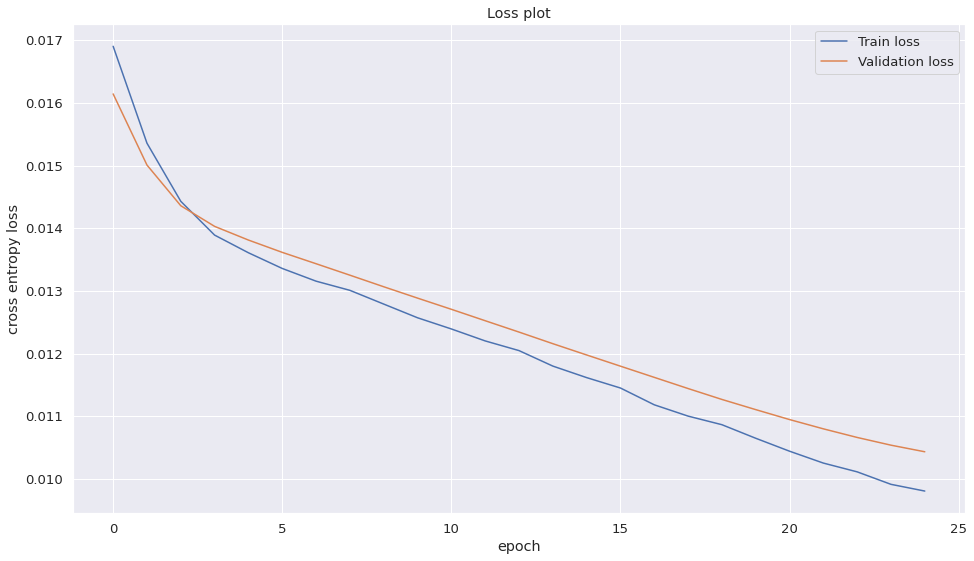

In [ ]:

plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_losses, label='Train loss')
plt.plot(np.arange(finished_epochs), val_losses, label='Validation loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('Loss plot')
plt.legend()
plt.show()

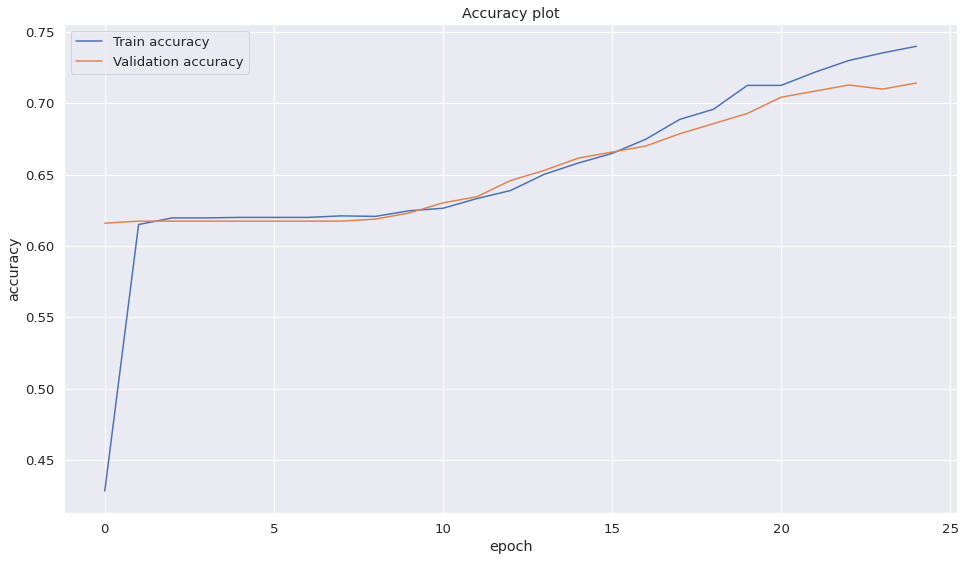

In [ ]:
plt.figure(figsize=(16, 9))
finished_epochs = len(train_losses)
plt.plot(np.arange(finished_epochs), train_acc, label='Train accuracy')
plt.plot(np.arange(finished_epochs), val_acc, label='Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy plot')
plt.legend()
plt.show()

In [ ]:
model.eval()

all_preds = []
all_answers = []
with torch.no_grad():
    for batch in test_iter:

        texts = batch.text.to(device=device)
        aspects = batch.aspect.to(device=device)
        sentiments = batch.sentiment.to(device=device)

        preds_scores, _ = model(texts, aspects)
        
        preds = torch.max(preds_scores, dim=-1)[1]
        all_preds += preds.tolist()
        all_answers += sentiments.tolist()


all_preds = np.array(all_preds)
all_answers = np.array(all_answers)

In [ ]:

accuracy = accuracy_score(all_preds, all_answers)

print(f'Accuracy: {accuracy:.5f}')

Accuracy: 0.78726


# Sample ABSA prediction

In [ ]:
from textblob import TextBlob
user_input=input("Enter a laptop review:\n\n") # ******* user input ******
tagged_user_input = pos_tag([user_input])
filter_tagged_user_input = filter_tag(tagged_user_input)

user_input_series = pd.Series(filter_tagged_user_input)
user_input_series_dtm = vect.transform(user_input_series)


predict_aspect= sgd.predict(user_input_series_dtm)
extra_feature=get_dict_aspect(predict_aspect, most_common_aspect)
extra_feature_dtm=DictVectorizer().fit_transform(extra_feature)
df = BIO_format(user_input, predict_aspect[0], final_most_common_aspect)
p=df.to_dict('split')['data']
print(df) #***** answer-1 ********

opt=['B','I']
term=df.loc[df["BIO"].isin(opt)]
print(list(term["text"])) #****** answer-2 ******

blob=TextBlob(user_input)
tokens=list(blob.words)
word=[]
sent=[]
c=0
i=0
for words,pos in blob.tags:
    if pos=='JJ' or pos=='NN' or pos=='JJR' or pos=='NNS':
        word.append(words)
if len(word)>=2:
  for i in range(len(word)):
   if len(word)>=2:
     firstw=word[0]
     secw=word[1]
     word.remove(firstw)
     word.remove(secw)
     findx=tokens.index(firstw)
     lindx=tokens.index(secw)
     sent.append(' '.join(tokens[findx:lindx+1]))

print("Sentiment terms:",sent) #******* answer-3 ********
for sentence in sent:
  if TextBlob(sentence).polarity<=0:
    polarity="Negative"
    print(sentence," : ",polarity) #******* answer-4 ********
  elif TextBlob(sentence).polarity>0:
    polarity="Positive"
    print(sentence," : ",polarity) #******* answer-4 ********
  else:
    polarity="Neutral"
    print(sentence," : ",polarity) #******* answer-4 *******

Enter a laptop review:

the size is large and the speaker is very good
      text BIO
0  the      B 
1  size     B 
2  is       O 
3  large    O 
4  and      O 
5  the      O 
6  speaker  O 
7  is       O 
8  very     O 
9  good     O 
['the', 'size']
Sentiment terms: ['size is large', 'speaker is very good']
size is large  :  Positive
speaker is very good  :  Positive
